# Bias-correct capacity factors for each REZ

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [39]:
# client.close()
# cluster.close()

In [40]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "01:00:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P dt6",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/xp65+gdata/w42+gdata/rt52+scratch/dt6"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [41]:
cluster.scale(jobs=1)
client = Client(cluster)

INFO:dask_jobqueue.pbs:Resource specification for PBS not set, initializing it to select=1:ncpus=24:mem=90GB


In [42]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.1:37453,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
# client = Client(threads_per_worker=1)
# client

In [5]:
import xarray as xr
import pandas as pd
import numpy as np

from scipy.optimize import root_scalar

import matplotlib.pyplot as plt

In [6]:
%cd /g/data/w42/dr6273/work/power_models
import functions as fn

/g/data/w42/dr6273/work/power_models


In [7]:
%load_ext autoreload
%autoreload 2

# Load data

REZ mask

In [8]:
mask = xr.open_dataset('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc').REZ

REZ capacity factors from ISP

In [9]:
def read_cfs(fuel_type):
    """
    Read and process AEMO ISP capacity factor data
    
    fuel_type: str, "wind_medium", "wind_high", "solarpv", "offshorewind_fixed" or "offshorewind_floating"
    """
    def p2f(x):
        return x.str.rstrip('%').astype('float') / 100.0#float(x.strip('%'))/100

    years = range(2011, 2024) # years of data
    
    df = pd.read_csv("rez_capacity_factors_" + fuel_type + ".csv", skiprows=2, index_col=0) # Read data
    df.columns = ["REZ_name", "Region"] + [int(y) for y in years] + ["Avg"] # rename columns
    df = df.dropna(axis=0) # Drop rows with NaN (i.e., zero capacity)
    df = df.drop(["REZ_name", "Region"], axis=1) # Drop columns
    
    return df.apply(p2f) # Convert percentage strings to float

In [10]:
isp_cfs = {}
for fuel_type in ["wind_medium", "wind_high", "solarpv"]:
    isp_cfs[fuel_type] = read_cfs(fuel_type)

In [11]:
# concat Onshore wind with offshore
#. Use fixed for all offshore except N10, which only has floating in ISP
_offshore_fixed = read_cfs("offshorewind_fixed")
_offshore_float = read_cfs("offshorewind_floating").loc["N10"].to_frame().T
_offshore = pd.concat([_offshore_float, _offshore_fixed])

In [12]:
isp_cfs["wind_medium"] = pd.concat([isp_cfs["wind_medium"], _offshore])
isp_cfs["wind_high"] = pd.concat([isp_cfs["wind_high"], _offshore])

In [13]:
isp_cfs["wind_medium"].tail()

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Avg
N11,0.42,0.39,0.42,0.43,0.41,0.40,0.41,0.42,0.40,0.41,0.41,0.41,0.43,0.41
V7,0.46,0.45,0.45,0.48,0.45,0.46,0.47,0.48,0.47,0.50,0.48,0.49,0.46,0.47
V8,0.43,0.46,0.45,0.47,0.43,0.43,0.44,0.45,0.45,0.48,0.45,0.48,0.44,0.45
S10,0.42,0.46,0.44,0.48,0.44,0.44,0.43,0.45,0.46,0.47,0.44,0.48,0.45,0.45
T4,0.48,0.49,0.46,0.51,0.46,0.47,0.48,0.50,0.50,0.52,0.49,0.50,0.47,0.49


ISP REZ generation data

In [14]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [15]:
# Tidy column names
_gen.columns = [i.replace("90", "9-") for i in _gen.columns]
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [16]:
# Sum scenarios with existing capacity
gen = _gen.copy()
for col in _gen.columns[2:]:
    if col[:3] == "Exi":
        pass
    else:
        gen_type = col.split("_")[-2]
        gen[col] = _gen[col] + _gen["Existing_" + gen_type]

Set some REZs to zero wind. In the ISP, they have no modelled transmission, and/or in the IASR Workbook there are no capacity factors because there is a resource limit of zero.

- N7 Tumut
- S5 Northern SA

In [17]:
gen.loc["N7", gen.columns[-10:]] = 0
gen.loc["S5", gen.columns[-10:]] = 0

In [18]:
gen_SC50 = gen[["Step_change_solar_2049-50", "Step_change_wind_2049-50"]]

In [19]:
gen_SC50.tail()

,Step_change_solar_2049-50,Step_change_wind_2049-50
REZ,,
V4,0,6350
V5,510,2000
V6,1948,0
V7,0,8200
V8,0,780


# Bias correct

- Bias correct the financial year mean of model data to match that in the IASR workbook
- Use leave-one-year-out cross validation
- Transform capacity factors (bounded, [0, 1]) to real number line using logit transformation
- Iterate to find a constant that will match the means

In [32]:
def find_logit_correction(x_model_da, mu_obs, eps=1e-6):
    """
    Bias correct an xarray.DataArray using logit transform + constant shift,
    such that the mean of the corrected data matches mu_obs.
    
    Parameters:
    -----------
    x_model_da: xr.DataArray
        Input data in the range (0, 1), with dims like (lat, lon, time).
        NaNs are supported and will be ignored in the correction.
        
    mu_obs: float
        Target mean to match after correction.
        
    eps: float
        Small value to clip data away from 0 and 1 before applying logit.
    
    Returns:
    --------
    xr.DataArray
        Bias-corrected data with the same shape and coordinates as input.
    """
    
    # Flatten non-NaN values for correction
    x_flat = x_model_da.values.flatten()
    mask_valid = ~np.isnan(x_flat)
    x_valid = x_flat[mask_valid]
    
    # Clip to avoid logit problems at 0 and 1
    x_valid = np.clip(x_valid, eps, 1 - eps)
    z = np.log(x_valid / (1 - x_valid))

    # Define function to match corrected mean to target
    def mean_diff(c):
        z_corr = z + c
        x_corr = 1 / (1 + np.exp(-z_corr))
        return np.mean(x_corr) - mu_obs
    
    # Solve for c using root finding
    result = root_scalar(mean_diff, bracket=[-10, 10], method='bisect')
    if not result.converged:
        raise RuntimeError("Failed to find bias correction shift")
    c = result.root
    return c

In [33]:
def logit_bias_correct(x_model_da, c, eps=1e-6):
    # Apply correction to full (non-NaN) data
    x_clipped = x_model_da.clip(min=eps, max=1 - eps)
    z_full = np.log(x_clipped / (1 - x_clipped))
    z_corrected = z_full + c
    x_corrected = 1 / (1 + np.exp(-z_corrected))

    # Return as DataArray with same coords
    return xr.DataArray(
        x_corrected,
        dims=x_model_da.dims,
        coords=x_model_da.coords,
        attrs=x_model_da.attrs
    )

In [34]:
def crossval_bias_correct_leave_one_year_out(x_model, mu_obs_series, eps=1e-6):
    """
    Perform leave-one-year-out bias correction using logit-shift.

    Parameters
    ----------
    x_model : xr.DataArray
        Modelled data in (0, 1), dims must include 'time' with datetime dtype.
    mu_obs_series : pd.Series
        Observed means indexed by year, where each value is the mean of all years except that one.
        Example: mu_obs_series.loc[2011] = mean(obs excluding 2011)
    eps : float
        Small value to clip values away from 0 and 1.

    Returns
    -------
    xr.DataArray
        Corrected model data, with each year corrected using mu_obs from all other years.
    """
    corrected_years = []

    for year in mu_obs_series.index:
        
        # Get financial year dates
        cv_dates = pd.date_range(str(year - 1) + "-07-01", str(year) + "-07-01", freq="h")[:-1]
        
        # Mask for year of interest and other years
        cv_year = x_model.time.isin(cv_dates)
        other_years = ~x_model.time.isin(cv_dates)
        
        # Keep relevant dates
        x_model_year = x_model.where(cv_year, drop=True)
        x_model_other = x_model.where(other_years, drop=True)
                
#         # Get modelled data for this year
#         x_model_year = x_model.sel(time=x_model['time.year'] == year)
        
# #         # Get modelled data for other years
# #         x_model_other = x_model.sel(time=x_model['time.year'] != year)

        # Use the precomputed mean for all years except this one
        mu_obs = mu_obs_series.loc[year]

        # Find bias between observed and modelled calibration years
        c = find_logit_correction(x_model_other, mu_obs)
        
        # Apply bias correction to this year
        x_corrected_year = logit_bias_correct(x_model_year, c, eps=eps)

        corrected_years.append(x_corrected_year)

    # Concatenate all years and sort by time
    return xr.concat(corrected_years, dim='time').sortby('time')

In [35]:
def leave_one_out_means(mu_obs_series):
    """
    Return a Series where each entry is the mean of all other entries.
    
    mu_obs_series: pandas Series
    """
    total_sum = mu_obs_series.sum()
    n = len(mu_obs_series)
    return (total_sum - mu_obs_series) / (n - 1)

### Generate CV statistics for all REZs

In [39]:
method = "van_der_Wiel"
years = range(2010, 2024)

In [95]:
for (gen_type, cf_type) in zip(["solar", "wind", "wind"][-2:], ["solarpv", "wind_medium", "wind_high"][-2:]):
    print(gen_type, cf_type)
    
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/bias_corrected/"
    
    # initialise empty DataFrame to fill will mean capacity factor statistics
    mean_cf_stats = pd.DataFrame(columns=["obs_mean", "raw_mean", "bc_mean"])
    
    # for r in mask.region.values:
    for r in ["N10"]:
        
        # Check if this REZ has an observed capacity factor
        check_rez = r in isp_cfs[cf_type].index
        
        if check_rez:
            print('T')
            
            # # Add this REZ to the dataframe
            mean_cf_stats.loc[r] = np.repeat(np.nan, 3)

            # Load capacity factors for this region only
            da_list = []
            for y in years:
                cf = fn.load_hourly_cf(y, gen_type, method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
                cf = cf.where(mask.sel(region=r) == 1, drop=True)
                da_list.append(cf)
            cf = xr.concat(da_list, dim="time")
            
            # Financial years
            cf = cf.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

            # Observed means
            mu_obs_all = isp_cfs[cf_type].loc[r].copy()["Avg"]
            
            # Mean of all other years (for cross validation)
            mu_obs_excl = leave_one_out_means(
                isp_cfs[cf_type].loc[r].copy().drop("Avg", axis=0)
            )
            
            # Bias corrected data using leave one year out
            cf_bc = crossval_bias_correct_leave_one_year_out(cf, mu_obs_excl)
            
            # Obs, raw and bias corrected means
            mean_cf_stats.loc[r, "obs_mean"] = mu_obs_all
            mean_cf_stats.loc[r, "raw_mean"] = cf.mean().values
            mean_cf_stats.loc[r, "bc_mean"] = cf_bc.mean().values
            print(mean_cf_stats)
#             # Correction factor over calibration period
#             c = find_logit_correction(cf_calib, mu_obs_all)

#             # Bias correct all data
#             cf_bc = logit_bias_correct(cf, c)
            # mean_cf_stats.loc[r, "bc_mean"] = cf_bc.sel(time=slice(str(calib_years[0] - 1) + "-07-01", str(calib_years[-1]) + "-06-30")).mean().values

            # to dataset, re-chunk and write
            # cf_bc = cf_bc.chunk({"time": -1})
            # cf_bc = cf_bc.to_dataset(name="capacity_factor")
            # cf_bc.to_netcdf(
            #     cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + r + ".nc",
            #     mode="w"
            # )
            
        else:
            pass
        
    # Write the capacity factor stats to file
    # mean_cf_stats.to_csv(
    #     cf_path + cf_type + "_capacity_factor_" + method + "_era5_REZ_statistics.csv"
    # )

wind wind_medium
T
     obs_mean  raw_mean   bc_mean
N10      0.43  0.358553  0.426928
wind wind_high
T
     obs_mean  raw_mean   bc_mean
N10      0.43  0.358553  0.426928


In [96]:
mean_cf_stats

,obs_mean,raw_mean,bc_mean
N10,0.43,0.358553,0.426928


# Process for all REZs

Raw capacity factor data

In [41]:
method = "van_der_Wiel"

In [42]:
all_years = range(1940, 2024)
calib_years = range(2011, 2024)

In [44]:
for (gen_type, cf_type) in zip(["solar", "wind", "wind"][1:], ["solarpv", "wind_medium", "wind_high"][1:]):

    print(gen_type, cf_type)
    
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/bias_corrected/"
    
    # for r in mask.region.values:
    for r in ["N10"]:
        
        # Check if this REZ has an observed capacity factor
        check_rez = r in isp_cfs[cf_type].index
        
        if check_rez:
            
            # Load capacity factors for this region only
            da_list = []
            for y in all_years:
                cf = fn.load_hourly_cf(y, gen_type, method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
                cf = cf.where(mask.sel(region=r) == 1, drop=True)
                da_list.append(cf)
            cf = xr.concat(da_list, dim="time")

            # Observed means
            mu_obs_all = isp_cfs[cf_type].loc[r].copy()["Avg"]

            # Data in calibration period
            cf_calib = cf.sel(time=slice(str(calib_years[0] - 1) + "-07-01", str(calib_years[-1]) + "-06-30"))

            # Correction factor over calibration period
            c = find_logit_correction(cf_calib, mu_obs_all)

            # Bias correct all data
            cf_bc = logit_bias_correct(cf, c)

            # to dataset, re-chunk and write
            cf_bc = cf_bc.chunk({"time": -1})
            cf_bc = cf_bc.to_dataset(name="capacity_factor")
            cf_bc.to_netcdf(
                cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + r + ".nc",
                mode="w"
            )
            
        else:
            pass

wind wind_medium
wind wind_high


# Illustration of method

In [20]:
import matplotlib.pyplot as plt

In [21]:
def FY_mean(da):
    """
    Get mean of each financial year
    
    da: array with 'time' dimension, starting in June, ending in July
    """
    return da.resample(time="1MS").mean().coarsen(time=12).mean()

In [22]:
def preprocess(ds):
    """
    Preprocess function for open_mfdataset.
    Selects Australian region and renames coords.
    """
    aus_region = [110, 155, -10, -45]
    ds = ds.sel(
        longitude=slice(aus_region[0], aus_region[1]),
        latitude=slice(aus_region[2], aus_region[3])
    )
    ds = ds.rename(
        {'longitude': 'lon',
         'latitude': 'lat'}
    )
    ds = ds.chunk({"time": -1, "lat": -1, "lon": -1})
    return ds

In [23]:
def capacity_factor_vdW(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3.5 # cut-in speed (m/s)
    W_r = 13 # rated speed
    W_1 = 25 # cut-out speed (m/s)
    
    # Cubic
    c_f = (W ** 3 - W_0 ** 3) / (W_r ** 3 - W_0 ** 3)
    c_f = c_f.where(W >= W_0, 0) # Set values below cut-in to zero
    c_f = c_f.where(W < W_r, 1) # Set values above rated speed to 1
    c_f = c_f.where(W < W_1, 0) # Set values above cut-off to zero
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [24]:
years = range(2010, 2024)

Capacity factor bias stats

In [25]:
cf_stats = {}
for (gen_type, cf_type) in zip(["solar", "wind", "wind"], ["solarpv", "wind_medium", "wind_high"]):
    
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/van_der_Wiel/bias_corrected/"

    cf_stats[cf_type] = pd.read_csv(
        cf_path + cf_type + "_capacity_factor_van_der_Wiel_era5_REZ_statistics.csv",
        index_col=0
    )

In [64]:
cf_stats["wind_medium"].head()

,obs_mean,raw_mean,bc_mean
Q1,0.42,0.099753,0.421533
Q2,0.33,0.093495,0.328461
Q4,0.30,0.075578,0.303077
Q5,0.30,0.122847,0.296149
Q6,0.32,0.068592,0.317690


### Central-West Orana

In [26]:
r = "N3" # Central-West Orana
method = "van_der_Wiel"

In [27]:
da_list = []
for y in years:
    cf = fn.load_hourly_cf(y, "wind", method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
    cf = cf.where(mask.sel(region=r) == 1, drop=True)
    da_list.append(cf)
cf_r_wind = xr.concat(da_list, dim="time")

In [28]:
da_list = []
for y in years:
    cf = fn.load_hourly_cf(y, "solar", method=method, add_dir="", chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
    cf = cf.where(mask.sel(region=r) == 1, drop=True)
    da_list.append(cf)
cf_r_solar = xr.concat(da_list, dim="time")

Load wind speed and radiation

In [29]:
ws_path = load_path = "/g/data/w42/dr6273/work/data/era5/100w/hourly/"
da_list = []
for y in years:
    w100 = xr.open_mfdataset(
        ws_path + "100w_era5_hourly_" + str(y) + "_Aus.nc",
        chunks={"lat": 50, "lon": 100}
    )["w100"]
    w100 = w100.where(mask.sel(region=r) == 1, drop=True)
    da_list.append(w100)
w100_r = xr.concat(da_list, dim="time")

In [30]:
rad_path = load_path = "/g/data/rt52/era5/single-levels/reanalysis/msdwswrf/"
da_list = []
for y in years:
    rad = xr.open_mfdataset(
        rad_path + "/" + str(y) + "/*.nc",
        preprocess=preprocess,
    )["msdwswrf"]
    rad = rad.where(mask.sel(region=r) == 1, drop=True)
    da_list.append(rad)
rad_r = xr.concat(da_list, dim="time")

Bias correction

In [36]:
mu_obs_excl = leave_one_out_means(
    isp_cfs["wind_medium"].loc[r].copy().drop("Avg", axis=0)
)

In [43]:
%%time
cf_r_bc_wind = crossval_bias_correct_leave_one_year_out(cf_r_wind, mu_obs_excl)

CPU times: user 23.9 s, sys: 1.66 s, total: 25.6 s
Wall time: 33 s


In [44]:
mu_obs_excl = leave_one_out_means(
    isp_cfs["solarpv"].loc[r].copy().drop("Avg", axis=0)
)

In [45]:
%%time
cf_r_bc_solar = crossval_bias_correct_leave_one_year_out(cf_r_solar, mu_obs_excl)

CPU times: user 22.8 s, sys: 1.4 s, total: 24.2 s
Wall time: 27.4 s


We want financial years to align with ISP data

In [46]:
w100_r = w100_r.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

In [47]:
cf_r_wind = cf_r_wind.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

In [48]:
cf_r_bc_wind = cf_r_bc_wind.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

In [49]:
rad_r = rad_r.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

In [50]:
cf_r_solar = cf_r_solar.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

In [51]:
cf_r_bc_solar = cf_r_bc_solar.sel(time=slice(str(years[0])+"-07", str(years[-1])+"-06"))

Plot

In [89]:
def rez_barplot(ax, cf_type):
    if cf_type == "wind_medium":
        ylim = 0.5
    elif cf_type == "solarpv":
        ylim = 0.4
        
    s = 10
    
    cf_stats[cf_type].reset_index().plot.scatter(ax=ax, x="index", y="obs_mean", color="k", s=s, label="AEMO")
    cf_stats[cf_type].reset_index().plot.scatter(ax=ax, x="index", y="raw_mean", color="tab:blue", s=s, marker="s", label="Raw")
    cf_stats[cf_type].reset_index().plot.scatter(ax=ax, x="index", y="bc_mean", color="tab:orange", s=s*1.5, marker="x", label="Corrected")
    # (cf_stats[cf_type]["obs_mean"] - cf_stats[cf_type]["raw_mean"]).plot.bar(ax=ax, zorder=0, color="gray", label="Diff")
    ax.legend(ncols=3, fontsize=8, loc=(-0.05, 1.05))
    ax.set_yticks([0, ylim/2, ylim])
    
    xlabels = []
    for label in list(cf_stats[cf_type].index)[::3]:
        xlabels.append(label)
        xlabels.append("")
        xlabels.append("")
    ax.set_xticklabels(xlabels)
    
    ax.set_ylabel("Capacity factor [-]")
    ax.set_xlabel("REZ")

In [102]:
def BC_ts(ax, cf_da, cf_bc_da, cf_type):
    _c = FY_mean(cf_bc_da.mean(["lat", "lon"]))

    xr.DataArray(
        isp_cfs[cf_type].loc[r].copy().drop("Avg", axis=0).values,
        dims=_c.dims,
        coords=_c.coords
    ).plot(ax=ax, label="AEMO", c="k", ls=":")
    
    _c.plot(ax=ax, color="tab:orange", label="Corrected")
    
    FY_mean(cf_da.mean(["lat", "lon"])).plot(ax=ax, color="tab:blue", ls="--", label="Raw")

    # ax.axhline(isp_cfs[cf_type].loc[r].copy()["Avg"], c="k", ls="--", label="AEMO mean")
    # ax.axhline(_c.mean(), c="tab:orange", ls="--", label="Corrected mean")
    ax.set_ylim(0, 0.4)
    ax.set_yticks([0, 0.2, 0.4])
    ax.legend(ncols=2, fontsize=8, loc=(0, 1.05))
    ax.set_title("")
    ax.set_ylabel("Capacity factor [-]")
    ax.set_xlabel("")

In [67]:
def sel_cell(ds, time=slice(None, None), lat=-31.75, lon=148.5):
    return ds.sel(time=time, lat=lat, lon=lon)

In [68]:
def plot_rez(ax, da, cbar_label="Capacity factor [-]"):
    da.mean("time").plot(ax=ax, cbar_kwargs={"label": cbar_label})
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

In [69]:
def plot_var_ts(ax, da, ylabel, time_slice=slice("2013-10-10", "2013-10-20")):
    sel_cell(da, time=time_slice).plot(ax=ax)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    ax.set_title("")

In [70]:
def plot_cf_ts(ax, raw, bc, time_slice=slice("2013-10-10", "2013-10-20")):
    sel_cell(raw, time=time_slice).plot(ax=ax, color="tab:blue", ls="--", label="Raw")
    sel_cell(bc, time=time_slice).plot(ax=ax, color="tab:orange", ls="-", label="Corrected")
    ax.set_ylabel("Capacity factor [-]")
    ax.set_xlabel("")
    ax.set_title("")
    # ax.legend(fontsize=8, loc=(0, 1.05))

In [71]:
def plot_cf_hist(ax, raw, bc):
    _ = ax.hist(sel_cell(raw), bins=20, density=True, color="tab:blue", alpha=0.5, label="Raw")
    _ = ax.hist(sel_cell(bc), bins=20, density=True, color="tab:orange", alpha=0.5, label="Corrected")
    ax.set_ylabel("Density [-]")
    ax.set_xlabel("Capacity factor [-]")
    ax.set_title("")
    # ax.legend(frameon=True, fontsize=8, loc=(0, 1.05))

In [72]:
def plot_turbine(ax, ws, time_slice=slice("2013-10-10", "2013-10-20")):
    x = xr.DataArray(np.linspace(0, 26, 100))
    p = capacity_factor_vdW(x)
    
    _ = ax.hist(sel_cell(ws, time=time_slice), "fd", density=True, label="Wind speed")
    ax.set_ylabel("Density [s/m]")
    ax.set_xlabel("Wind speed [m/s]")
    # ax.axvline(3.5, c="k")
    # ax.axvline(13, c="k")
    # ax.axvline(ws.mean().values, c="r")

    ax2=ax.twinx()
    ax2.plot(x, p, c="k", label="Power curve")
    ax2.set_yticklabels([])
    # ax2.set_ylabel("Capacity factor [-]")

In [73]:
plt_params = {
    'lines.linewidth': 0.9,
    # 'hatch.linewidth': 0.5,
    'font.size': 8,
    'legend.fontsize' : 8,
    # 'legend.columnspacing': 0.7,
    # 'legend.labelspacing' : 0.03,
    # 'legend.handlelength' : 1.,
    # 'axes.linewidth': 0.5
}

In [74]:
%matplotlib inline

Wind

/jobfs/152624742.gadi-pbs/ipykernel_859222/571149593.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


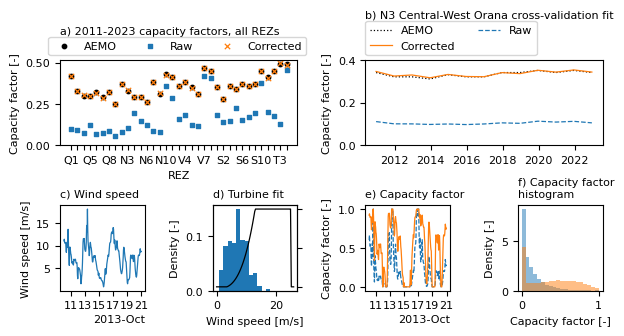

In [105]:
with plt.rc_context(plt_params):
    fig = plt.figure(figsize=(7,3))

    gs = fig.add_gridspec(2, 4)#, width_ratios=[0.4, 0.6], height_ratios=[0.5, 0.5])

    ax00 = fig.add_subplot(gs[0,:2])
    ax01 = fig.add_subplot(gs[0,2:])
    ax10 = fig.add_subplot(gs[1,0])
    ax11 = fig.add_subplot(gs[1,1])
    ax12 = fig.add_subplot(gs[1,2])
    ax13 = fig.add_subplot(gs[1,3])
    # ax20 = fig.add_subplot(gs[2,0])
    # ax22 = fig.add_subplot(gs[2,2])
    # ax23 = fig.add_subplot(gs[2,3])

    # All REZ barplot
    rez_barplot(ax00, "wind_medium")
    ax00.set_title("a) 2011-2023 capacity factors, all REZs", y=1.2, fontsize=8, loc="left")

    # CV time series
    BC_ts(ax01, cf_r_wind, cf_r_bc_wind, "wind_medium")
    ax01.set_title("b) N3 Central-West Orana cross-validation fit", y=1.4, fontsize=8, loc="left")
    
    # Variable time series
    plot_var_ts(ax10, w100_r, "Wind speed [m/s]")
    ax10.set_title("c) Wind speed", fontsize=8, loc="left")
    # Turbine curve
    plot_turbine(ax11, w100_r)
    ax11.set_title("d) Turbine fit", fontsize=8, loc="left")
    # CF time series
    plot_cf_ts(ax12, cf_r_wind, cf_r_bc_wind)
    ax12.set_title("e) Capacity factor", fontsize=8, loc="left")
    # CF histogram
    plot_cf_hist(ax13, cf_r_wind, cf_r_bc_wind)
    ax13.set_title("f) Capacity factor\nhistogram", fontsize=8, loc="left")

    # Input variable mean
    # plot_rez(ax20, w100_r, "Wind speed [m/s]")
    # ax20.set_title("g) N3 wind speed", fontsize=8, loc="left")
    # # Raw cf
    # plot_rez(ax22, cf_r_wind)
    # ax22.set_title("h) N3 raw cf", fontsize=8, loc="left")
    # # BS cf
    # plot_rez(ax23, cf_r_bc_wind)
    # ax23.set_title("i) N3 corrected cf", fontsize=8, loc="left")

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.8, hspace=0.7)

    plt.savefig("figures/model_fit_wind.pdf", format="pdf", bbox_inches="tight")

Solar

In [93]:
def cell_temperature(T, G, V):
    """
    Calculates solar cell temperature.
    
    T: daytime temperature or hourly temperature (deg C)
    G: incoming solar radiation (W/m^2)
    V: wind speed at 10 m (m/s)
    """
    c1 = 4.3 # deg C
    c2 = 0.943
    c3 = 0.028 # deg C m^2 / W
    c4 = -1.528 # deg C s / m
    
    return c1 + (c2 * T) + (c3 * G) + (c4 * V)

In [94]:
def performance_ratio(T_cell):
    """
    Calculate performance ratio (unitless).
    
    T_cell: cell temperature (deg C)
    """
    T_ref = 25 # reference temperature (deg C)
    gamma = -0.005 # constant
    
    return  1 + gamma * (T_cell - T_ref)

Performance ratio

For radiation of 100 W/m^2, as a function of daytime temperature and wind speed.

Trying to replicate fig S2 from: https://ars.els-cdn.com/content/image/1-s2.0-S1364032119302862-mmc1.pdf

In [95]:
dummy_t = np.linspace(-10, 40, 100)
dummy_w = np.linspace(0, 25, 100)

In [96]:
P_R = np.empty((100, 100))

In [107]:
for i,w in enumerate(dummy_w):
    for j, t in enumerate(dummy_t):
        T_cell = cell_temperature(t, 500, w)
        P_R[i, j] = performance_ratio(T_cell)

In [108]:
P_R = xr.DataArray(
    P_R.transpose(),
    dims = ['cell_T [deg C]', 'W [m/s]'],
    coords = {'cell_T [deg C]': dummy_t, 'W [m/s]': dummy_w}
)

In [109]:
def plot_panel(ax, pr):
    pr.plot.contourf(ax=ax, vmin=0.8, vmax=1.4, cbar_kwargs={"label": "", "ticks": np.arange(0.8, 1.41, 0.2)})
    ax.set_xlabel("Wind speed [m/s]")
    ax.set_ylabel(r"Temperature [$^{\circ}$C]")

/jobfs/152624742.gadi-pbs/ipykernel_859222/571149593.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


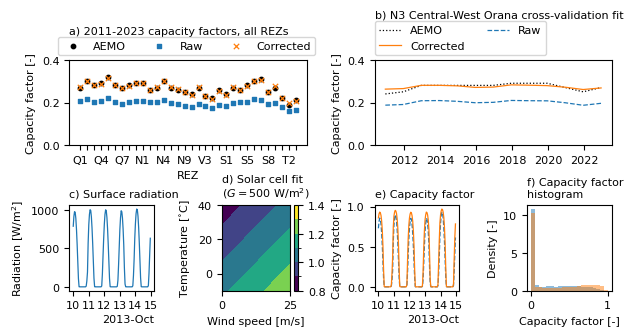

In [114]:
with plt.rc_context(plt_params):
    fig = plt.figure(figsize=(7,3))

    gs = fig.add_gridspec(2, 4)#, width_ratios=[0.4, 0.6], height_ratios=[0.5, 0.5])

    ax00 = fig.add_subplot(gs[0,:2])
    ax01 = fig.add_subplot(gs[0,2:])
    ax10 = fig.add_subplot(gs[1,0])
    ax11 = fig.add_subplot(gs[1,1])
    ax12 = fig.add_subplot(gs[1,2])
    ax13 = fig.add_subplot(gs[1,3])
    # ax20 = fig.add_subplot(gs[2,0])
    # ax22 = fig.add_subplot(gs[2,2])
    # ax23 = fig.add_subplot(gs[2,3])

    # All REZ barplot
    rez_barplot(ax00, "solarpv")
    ax00.set_title("a) 2011-2023 capacity factors, all REZs", y=1.2, fontsize=8, loc="left")

    # CV time series
    BC_ts(ax01, cf_r_solar, cf_r_bc_solar, "solarpv")
    ax01.set_title("b) N3 Central-West Orana cross-validation fit", y=1.4, fontsize=8, loc="left")
    
    # Variable time series
    plot_var_ts(ax10, rad_r, r"Radiation [W/m${^2}$]", time_slice=slice("2013-10-10", "2013-10-14"))
    ax10.set_title("c) Surface radiation", fontsize=8, loc="left")
    # Solar panel fit
    plot_panel(ax11 ,P_R)
    ax11.set_title("d) Solar cell fit\n"+r"($G=500$ W/m${^2}$)", fontsize=8, loc="left")
    # CF time series
    plot_cf_ts(ax12, cf_r_solar, cf_r_bc_solar, time_slice=slice("2013-10-10", "2013-10-14"))
    ax12.set_title("e) Capacity factor", fontsize=8, loc="left")
    # CF histogram
    plot_cf_hist(ax13, cf_r_solar, cf_r_bc_solar)
    ax13.set_title("f) Capacity factor\nhistogram", fontsize=8, loc="left")

    # # Input variable mean
    # plot_rez(ax20, rad_r, "Radiation [W/(m^2)]")
    # ax20.set_title("g) N3 radiation", fontsize=8, loc="left")
    # # Raw cf
    # plot_rez(ax22, cf_r_solar)
    # ax22.set_title("h) N3 raw cf", fontsize=8, loc="left")
    # # BS cf
    # plot_rez(ax23, cf_r_bc_solar)
    # ax23.set_title("i) N3 corrected cf", fontsize=8, loc="left")

    # plt.tight_layout()
    plt.subplots_adjust(wspace=0.8, hspace=0.7)

    plt.savefig("figures/model_fit_solar.pdf", format="pdf", bbox_inches="tight")